# Cistopic analysis

In [1]:
import os
import pycisTopic
from pycisTopic.cistopic_class import create_cistopic_object
pycisTopic.__version__

'2.0a0'

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [3]:
root_dir = Path("/tscc/projects/ps-epigen/users/biy022/biccn/data/SNAREdata/scenicplus/")
os.chdir(root_dir / "VIP")

In [4]:
!mkdir -p pycistopic_outputs

In [5]:
## Some meta information
path_to_blacklist = "/tscc/projects/ps-epigen/users/biy022/scmethylhic/genome/hg38_blacklist.v2.bed.gz"

In [6]:
## Prepare the sample_id pd.Dataframe, not sure if this is necessary
meta_df = pd.read_csv("VIP_meta_data.tsv", header=0, sep="\t", index_col=0)
meta_df["sample_id"] = "VIP"

In [7]:
import scanpy as sc
atac_adata = sc.read_h5ad("VIP_atac_matrix.h5ad")

In [8]:
cell_names_tb = pd.read_csv("VIP_cell_barcodes.tsv", header=None, sep="\t")
cell_names = cell_names_tb[0].tolist()
region_names_tb = pd.read_csv("VIP_atac_regions.tsv", header=None, sep="\t")
region_names = region_names_tb[0].tolist()
region_names = ["{}:{}-{}".format(*x.split("-")) for x in region_names]

In [9]:
cistopic_object = create_cistopic_object(
    fragment_matrix=atac_adata.X.T.tocsr(),
    cell_names=cell_names,
    region_names=region_names,
    path_to_blacklist=path_to_blacklist,
    project="VIP",
    tag_cells=False
)

2025-03-05 11:06:11,749 cisTopic     INFO     Removing blacklisted regions
2025-03-05 11:06:13,655 cisTopic     INFO     Creating CistopicObject
2025-03-05 11:06:15,384 cisTopic     INFO     Done!


In [10]:
cistopic_object.add_cell_data(meta_df)

Columns ['sample_id'] will be overwritten


In [11]:
print(cistopic_object)

CistopicObject from project VIP with n_cells × n_regions = 53967 × 552298


In [12]:
import pickle
pickle.dump(
    cistopic_object,
    open("pycistopic_outputs/cistopic_object.pickle", "wb")
)

In [13]:
# dispatch models to different clusters
!mkdir -p pycistopic_slurm/

In [14]:
slurm_script_template = (
    "#!/bin/bash\n"
    "#SBATCH -p condo\n"
    "#SBATCH -q condo\n"
    "#SBATCH -J {0}\n"
    "#SBATCH -N 3\n"
    "#SBATCH -c 8\n"
    "#SBATCH --mem 300G\n"
    "#SBATCH -t 8:00:00\n"
    "#SBATCH -o /tscc/projects/ps-epigen/users/biy022/biccn/data/SNAREdata/scenicplus/VIP/pycistopic_slurm/{0}.out\n"
    "#SBATCH -e /tscc/projects/ps-epigen/users/biy022/biccn/data/SNAREdata/scenicplus/VIP/pycistopic_slurm/{0}.err\n"
    "#SBATCH --mail-user biy022@health.ucsd.edu\n"
    "#SBATCH --mail-type FAIL\n"
    "#SBATCH -A csd772\n"
    "\n"
    "set -e\n"
    "source ~/.bashrc\n"
    "conda activate scenicplus\n"
    "\n"
    "cd /tscc/projects/ps-epigen/users/biy022/biccn/analysis/scenicplus/VIP/\n"
    "python3 02.1_mallet_script.py {0} "
    "/tscc/projects/ps-epigen/users/biy022/biccn/data/SNAREdata/scenicplus/VIP/pycistopic_outputs/cistopic_object.pickle\n"
)

In [15]:
for n_topic in [2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]:
    with open("pycistopic_slurm/model_{}_slurm.sh".format(n_topic), "w") as f:
        f.write(slurm_script_template.format(n_topic))

In [16]:
# Run models in cluster

## Run cistopic

In [4]:
cistopic_object = pickle.load(open("pycistopic_outputs/cistopic_object.pickle", "rb"))

/tscc/nfs/home/biy022/miniconda3/envs/scenicplus/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-03-05 13:36:18,018	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [5]:
models = []
for file in os.listdir("pycistopic_outputs"):
    if file.startswith("Topic") and file.endswith(".pkl"):
        model = pickle.load(open(os.path.join("pycistopic_outputs/", file), "rb"))
        models.append(model)

In [6]:
pickle.dump(
    models,
    open("pycistopic_outputs/cistopic_models.pkl", "wb")
)

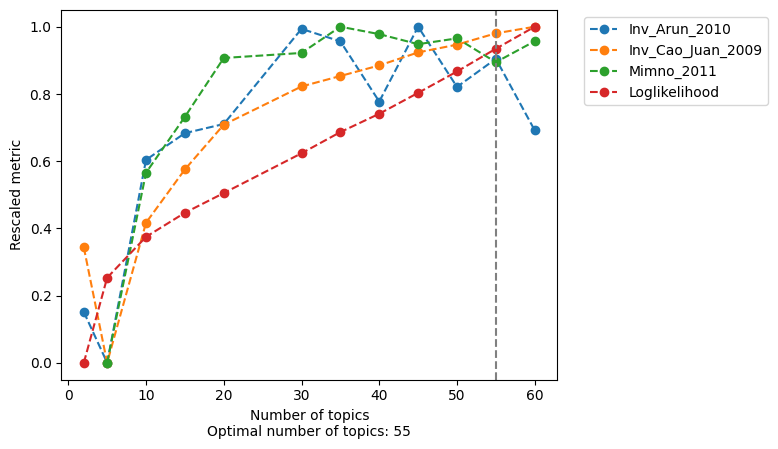

In [7]:
from pycisTopic.lda_models import evaluate_models
model = evaluate_models(models, return_model = True)

In [8]:
cistopic_object.add_LDA_model(model)
pickle.dump(
    cistopic_object,
    open("pycistopic_outputs/cistopic_object.pickle", "wb")
)

## Clustering with cell to topics distributions

In [9]:
from pycisTopic.clust_vis import (
    find_clusters,
    run_umap,
    run_tsne,
    plot_metadata,
    plot_topic,
    cell_topic_heatmap,
    harmony
)

In [10]:
cistopic_object = pickle.load(open("pycistopic_outputs/cistopic_object.pickle", "rb"))

In [11]:
find_clusters(
    cistopic_object,
    target="cell",
    k=20,
    res=[0.2, 0.4, 0.6, 0.8, 1.0],
    prefix="pycisTopic_",
    scale=True
)

2025-03-05 13:36:42,345 cisTopic     INFO     Finding neighbours
Columns ['pycisTopic_leiden_20_0.2'] will be overwritten
Columns ['pycisTopic_leiden_20_0.4'] will be overwritten
Columns ['pycisTopic_leiden_20_0.6'] will be overwritten
Columns ['pycisTopic_leiden_20_0.8'] will be overwritten
Columns ['pycisTopic_leiden_20_1.0'] will be overwritten


In [12]:
run_umap(cistopic_object, target="cell", scale=True)

2025-03-05 13:38:06,215 cisTopic     INFO     Running UMAP


/tscc/nfs/home/biy022/miniconda3/envs/scenicplus/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


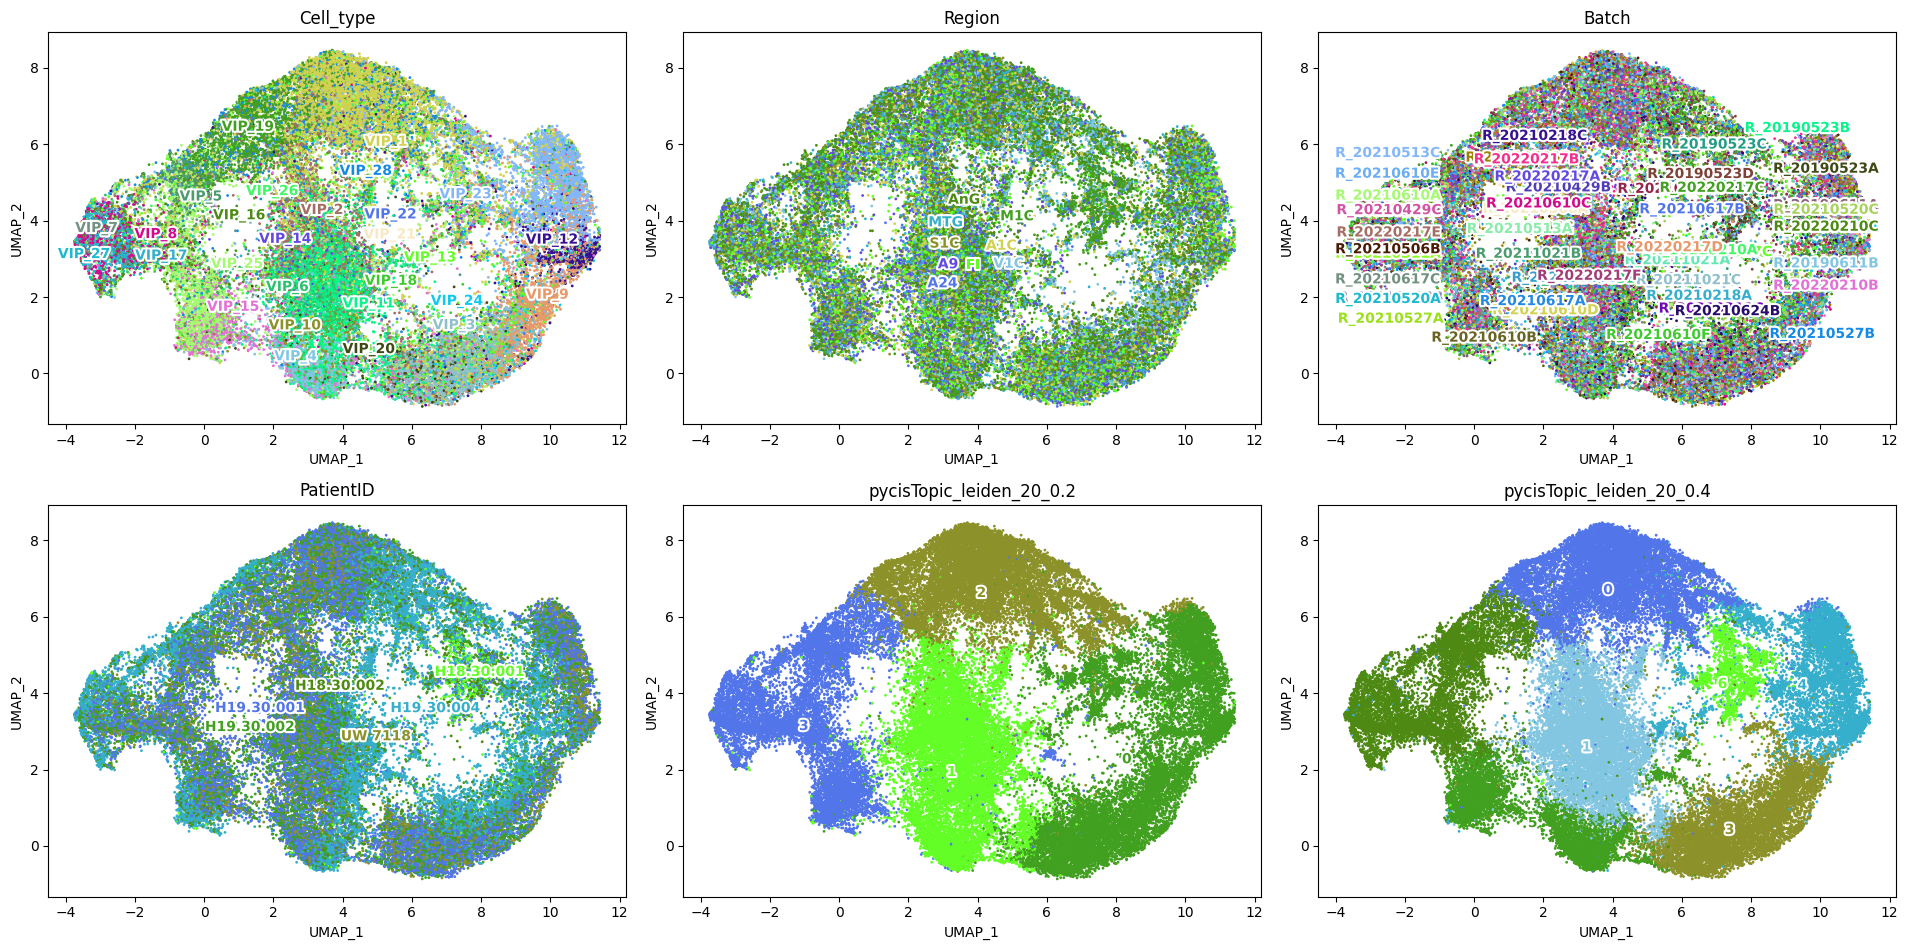

In [13]:
plot_metadata(
    cistopic_object,
    reduction_name="UMAP",
    variables=[
        "Cell_type", 
        "Region", 
        "Batch", 
        "PatientID",
        "pycisTopic_leiden_20_0.2",
        "pycisTopic_leiden_20_0.4"
    ],
    target="cell",
    num_columns=3,
    text_size=10,
    dot_size=1,
    show_legend=False
)

In [14]:
pickle.dump(
    cistopic_object,
    open("pycistopic_outputs/cistopic_object.pickle", "wb")
)

## Topic binarization

In [15]:
from pycisTopic.topic_binarization import binarize_topics

In [16]:
cistopic_object = pickle.load(open("pycistopic_outputs/cistopic_object.pickle", "rb"))

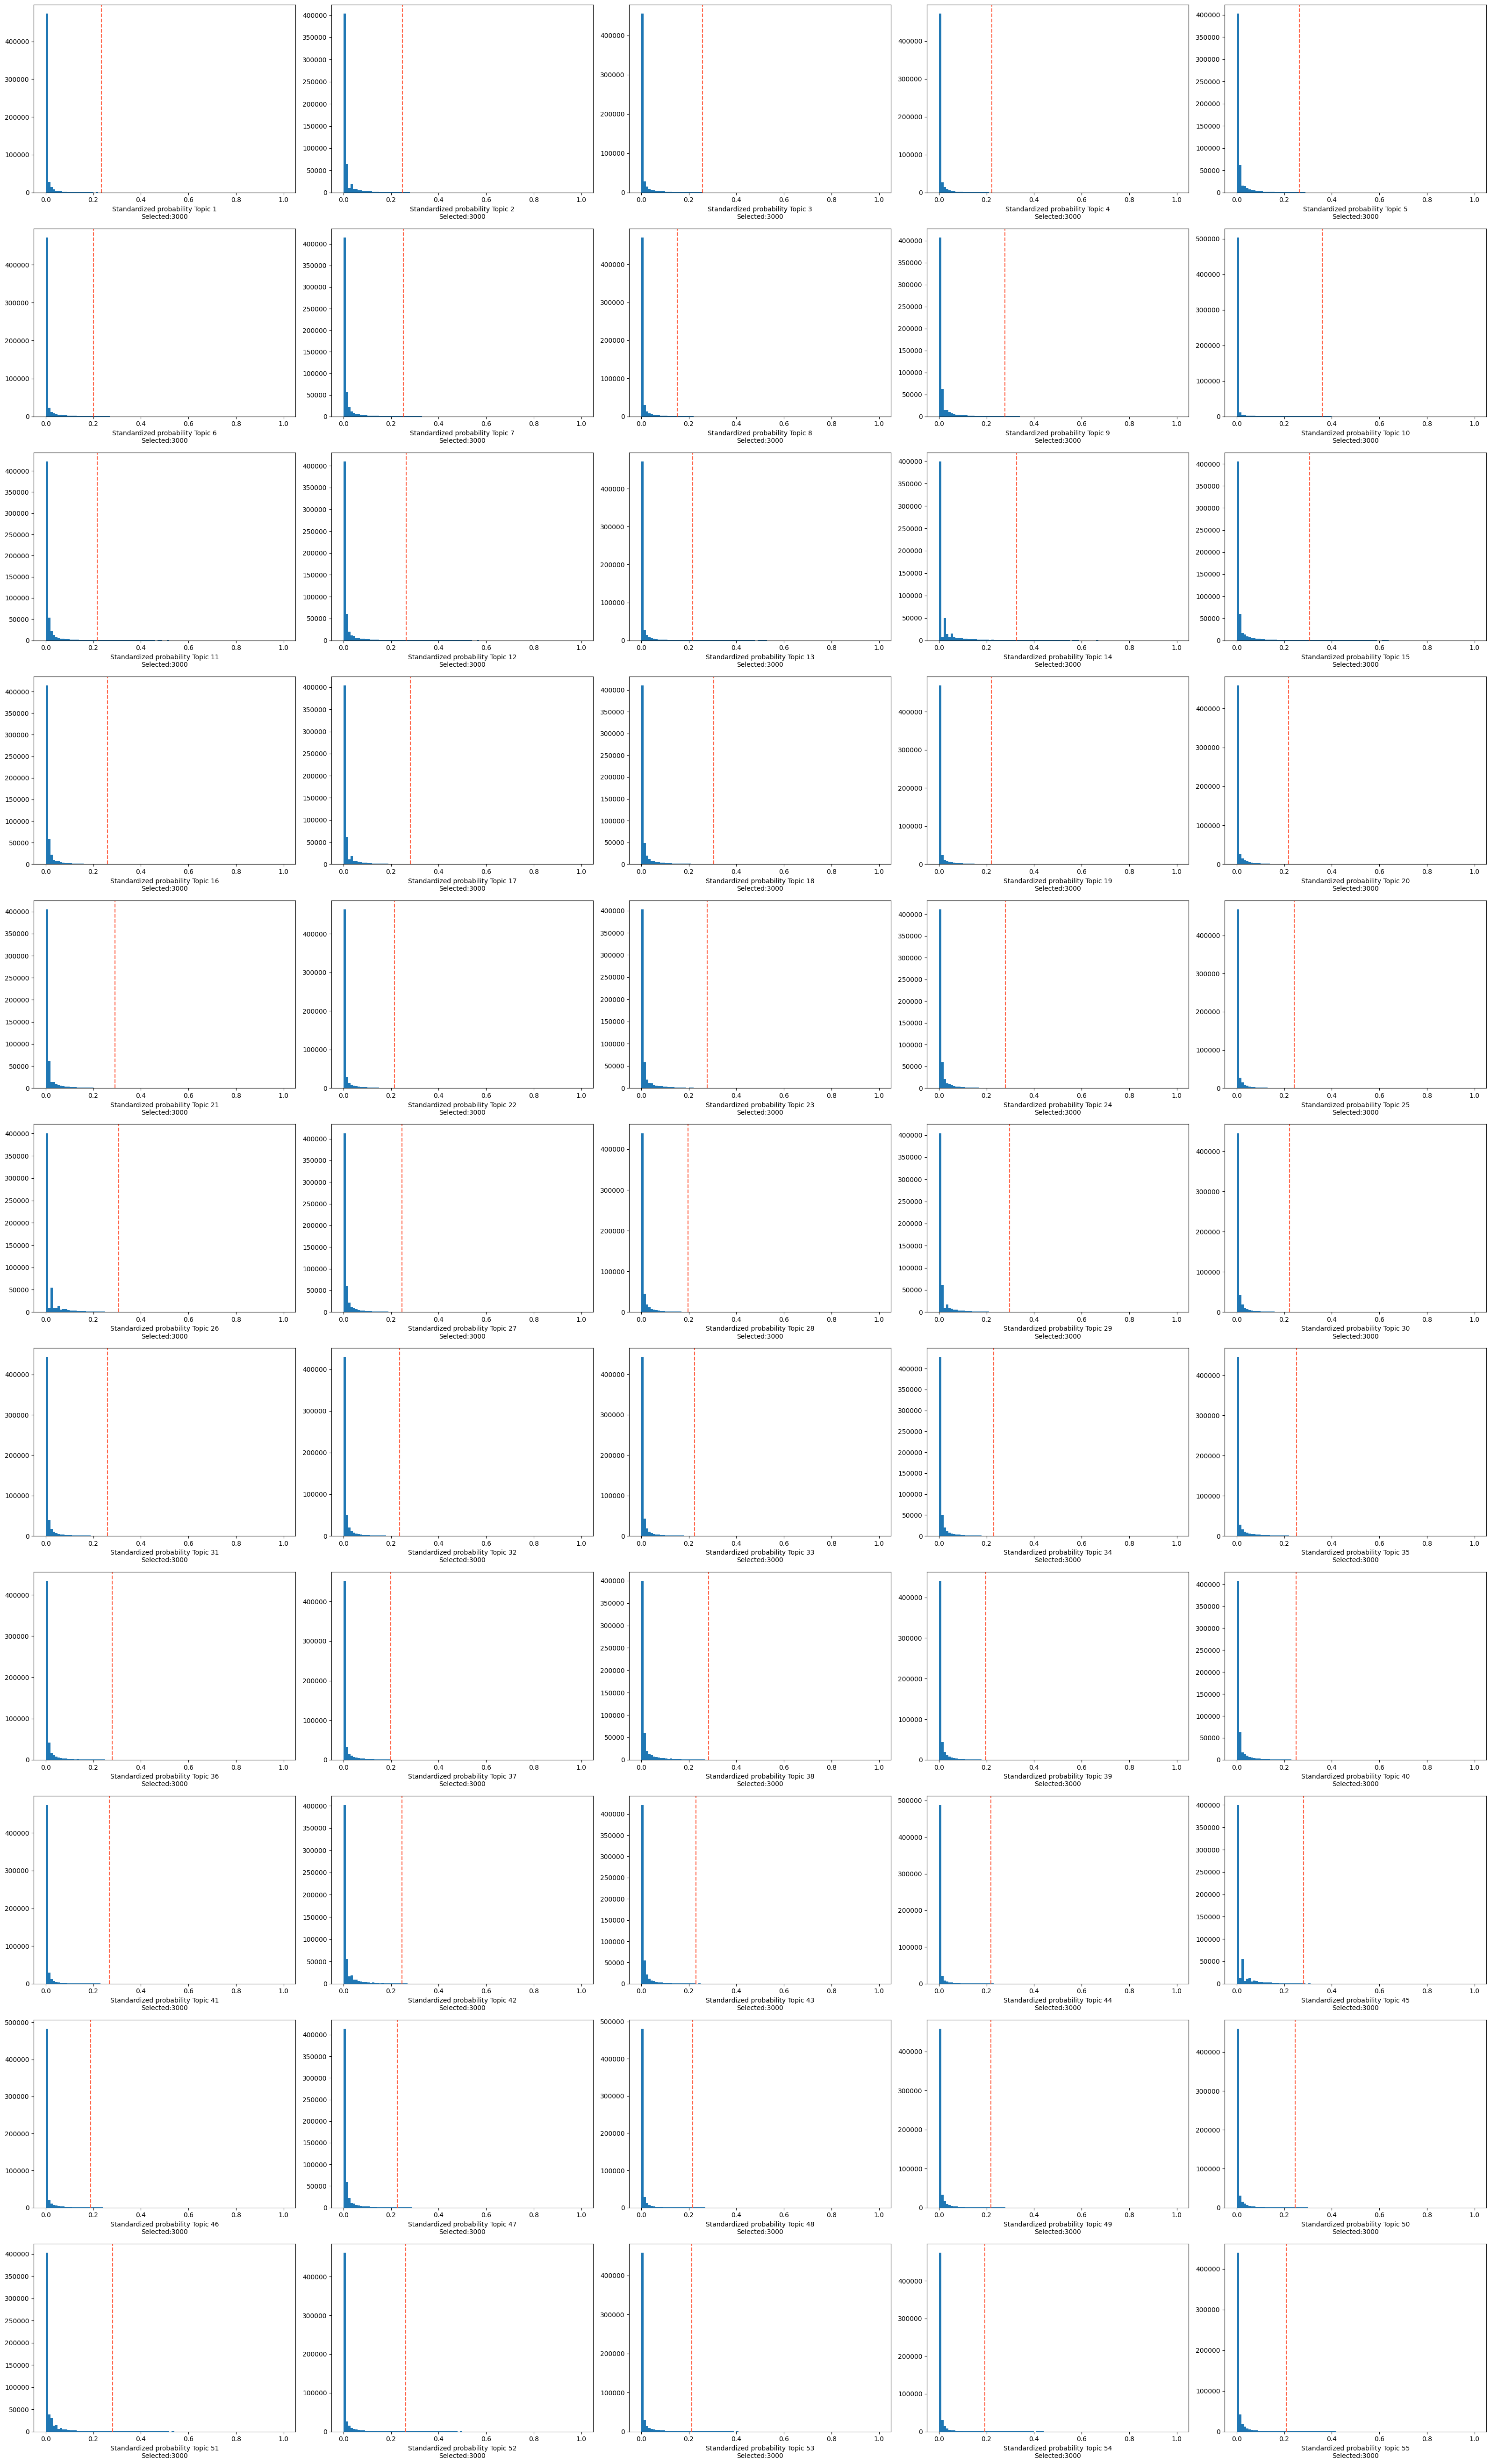

In [17]:
region_bin_topics_top_3k = binarize_topics(
    cistopic_object, method='ntop', ntop = 3_000,
    plot=True, num_columns=5
)

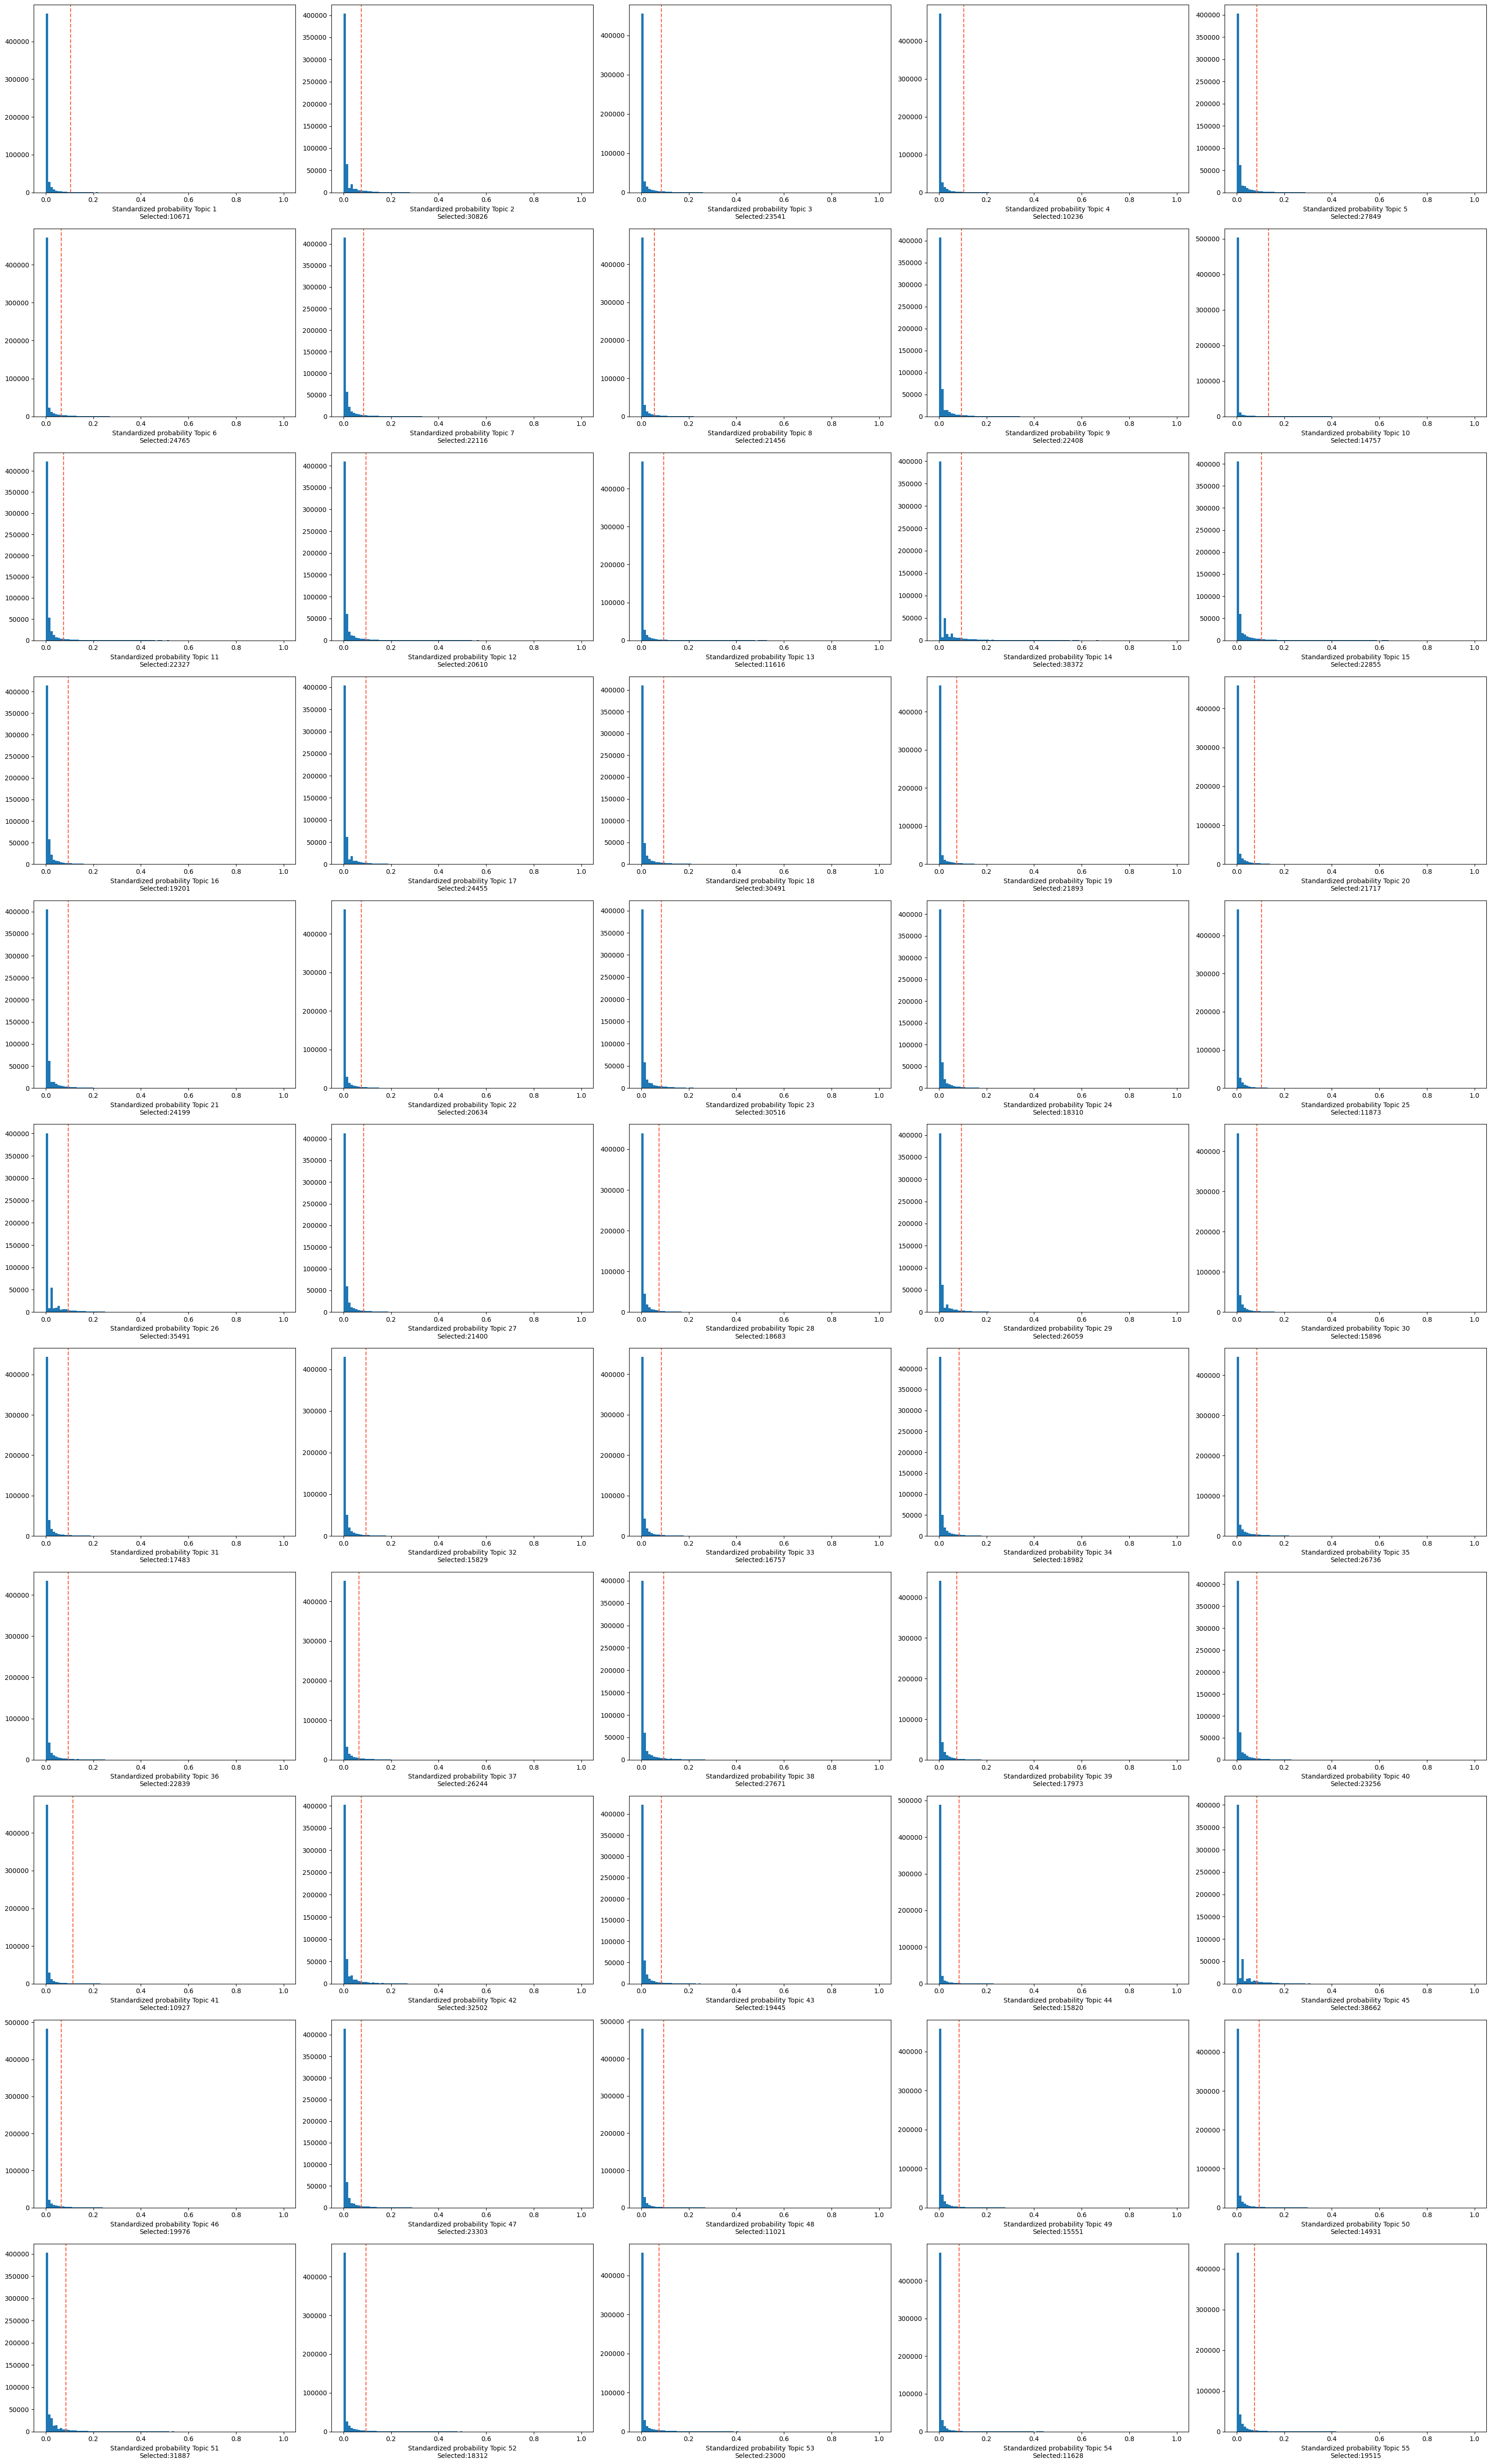

In [18]:
region_bin_topics_otsu = binarize_topics(
    cistopic_object, method='otsu',
    plot=True, num_columns=5
)

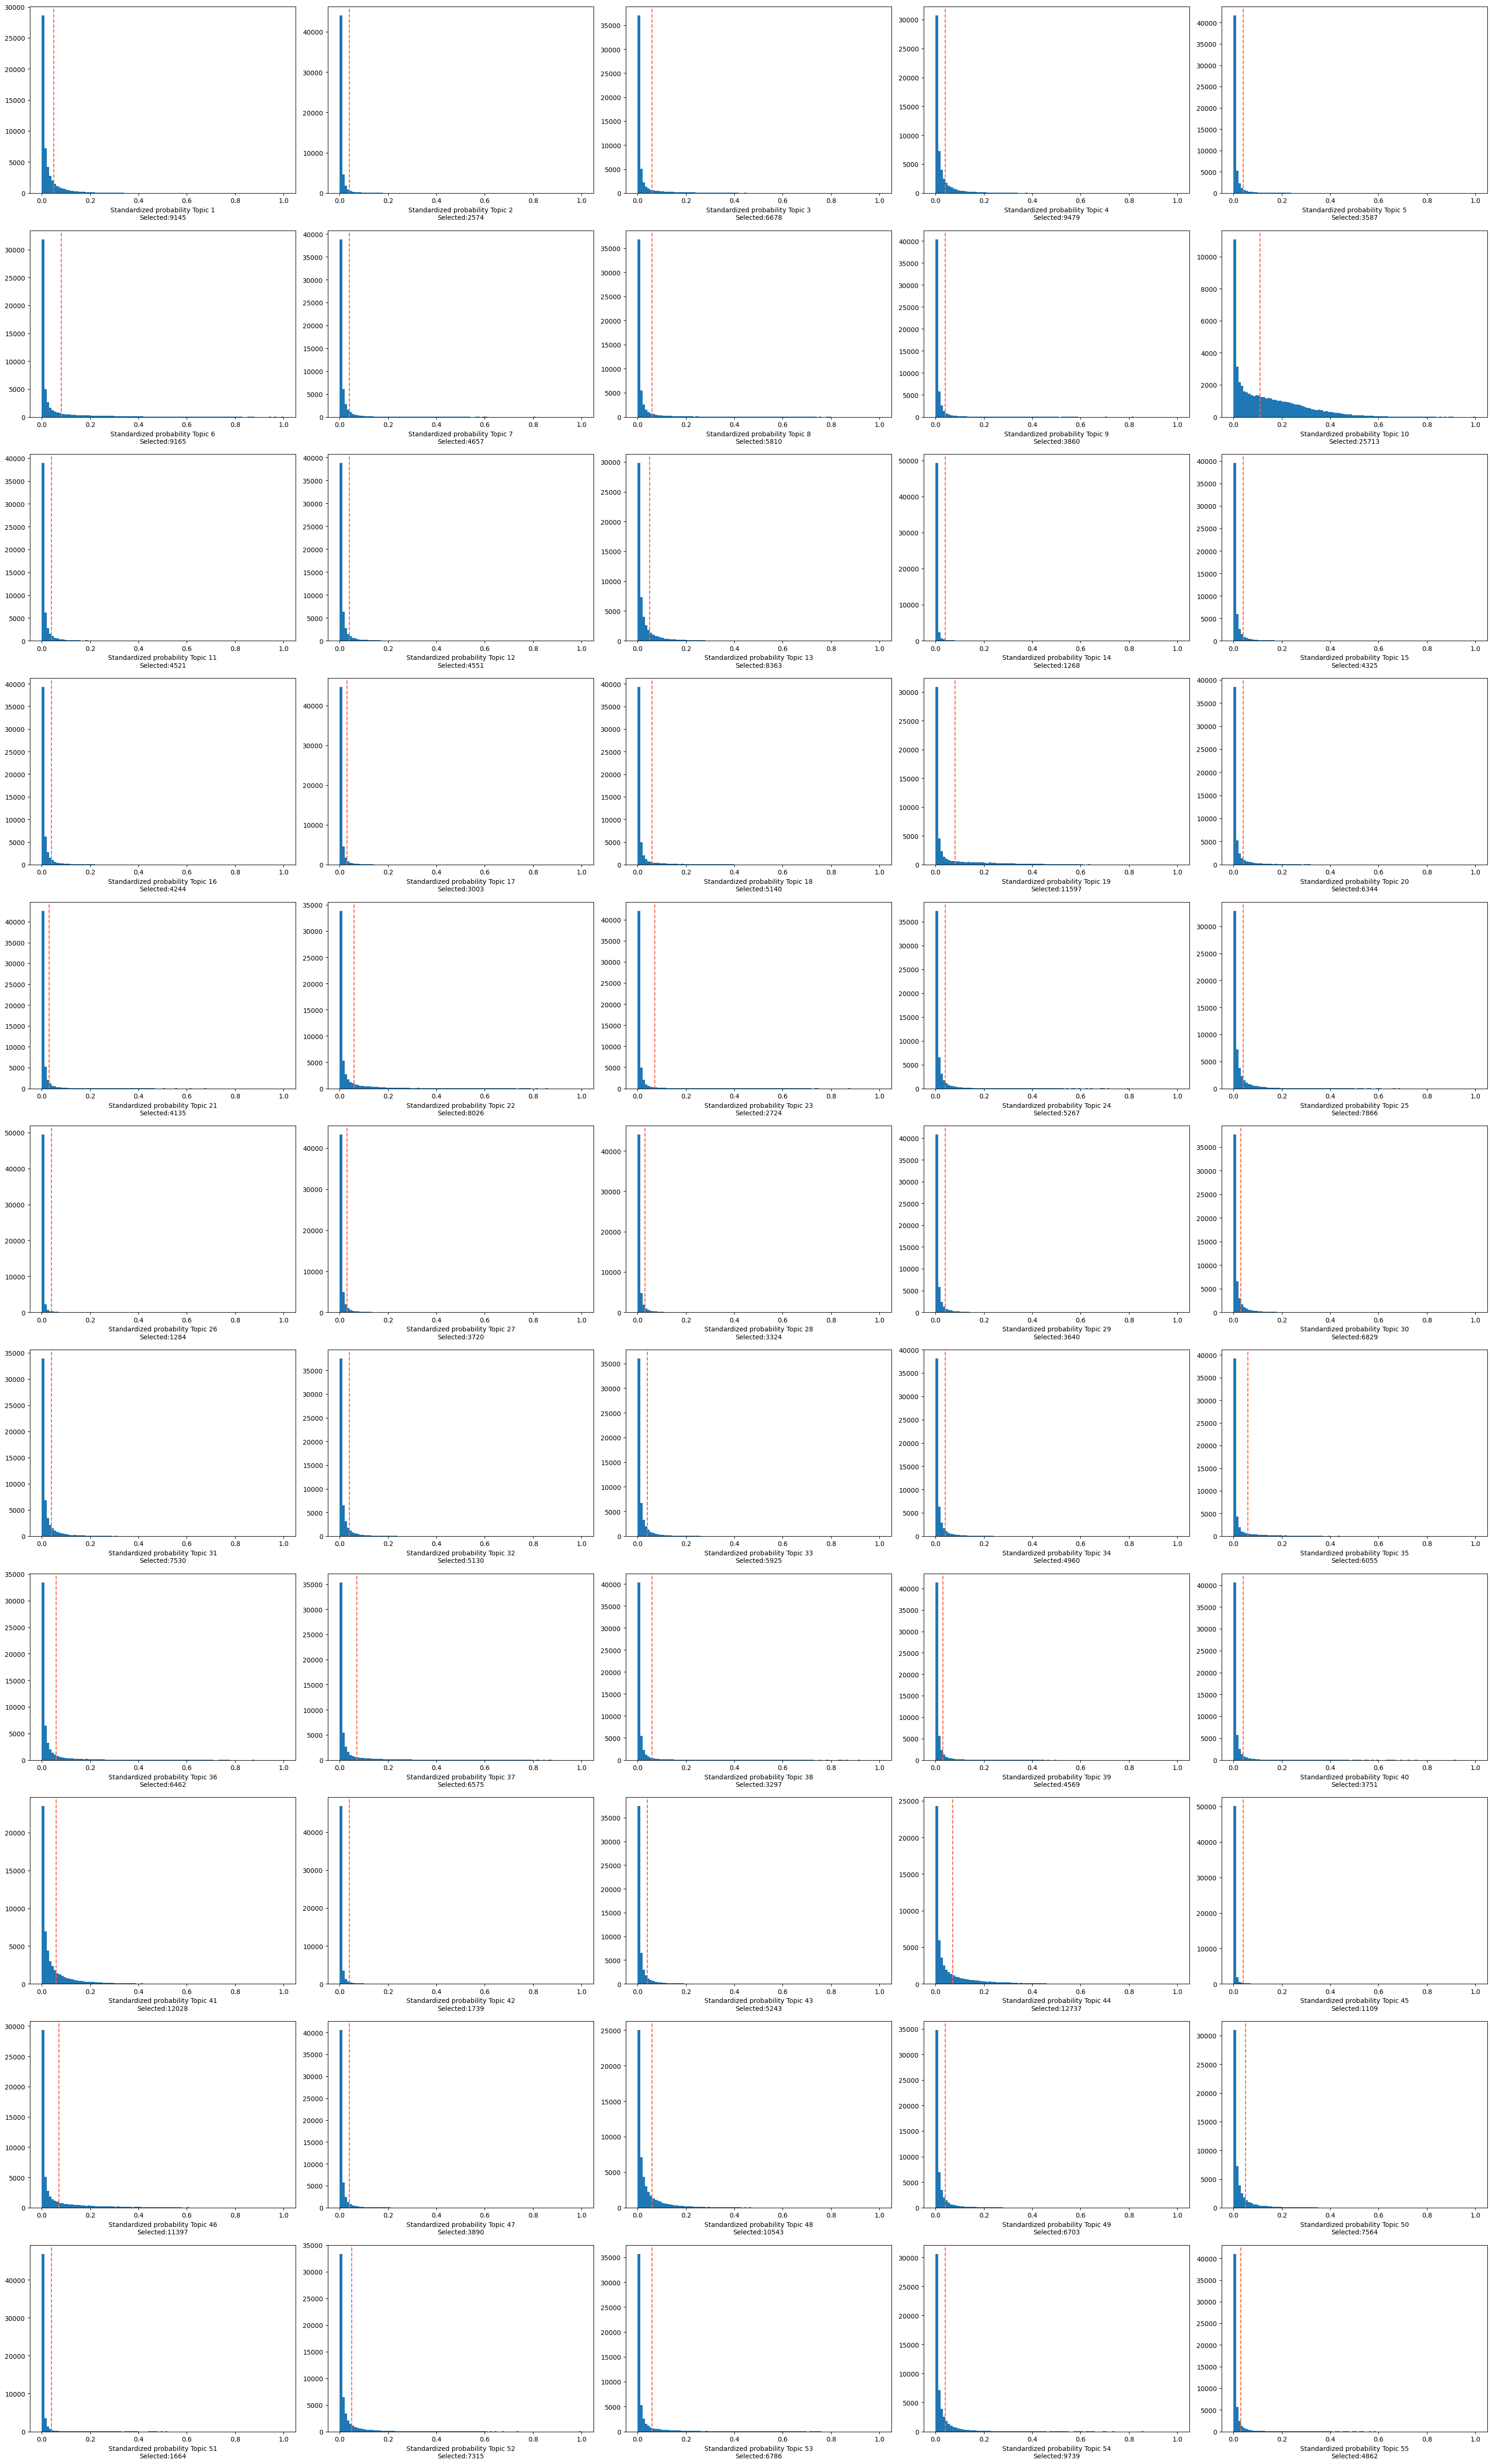

In [19]:
binarized_cell_topic = binarize_topics(
    cistopic_object,
    target="cell",
    method="li",
    plot=True,
    num_columns=5, 
    nbins=100
)

In [20]:
from pycisTopic.topic_qc import compute_topic_metrics, plot_topic_qc, topic_annotation
import matplotlib.pyplot as plt
from pycisTopic.utils import fig2img

In [21]:
topic_qc_metrics = compute_topic_metrics(cistopic_object)

In [22]:
fig_dict={}
fig_dict['CoherenceVSAssignments'] = plot_topic_qc(
    topic_qc_metrics, var_x='Coherence', var_y='Log10_Assignments', 
    var_color='Gini_index', plot=False, return_fig=True
)
fig_dict['AssignmentsVSCells_in_bin'] = plot_topic_qc(
    topic_qc_metrics, var_x='Log10_Assignments', var_y='Cells_in_binarized_topic', 
    var_color='Gini_index', plot=False, return_fig=True
)
fig_dict['CoherenceVSCells_in_bin'] = plot_topic_qc(
    topic_qc_metrics, var_x='Coherence', var_y='Cells_in_binarized_topic', 
    var_color='Gini_index', plot=False, return_fig=True
)
fig_dict['CoherenceVSRegions_in_bin'] = plot_topic_qc(
    topic_qc_metrics, var_x='Coherence', var_y='Regions_in_binarized_topic', 
    var_color='Gini_index', plot=False, return_fig=True
)
fig_dict['CoherenceVSMarginal_dist'] = plot_topic_qc(
    topic_qc_metrics, var_x='Coherence', var_y='Marginal_topic_dist', 
    var_color='Gini_index', plot=False, return_fig=True
)
fig_dict['CoherenceVSGini_index'] = plot_topic_qc(
    topic_qc_metrics, var_x='Coherence', var_y='Gini_index', 
    var_color='Gini_index', plot=False, return_fig=True
)

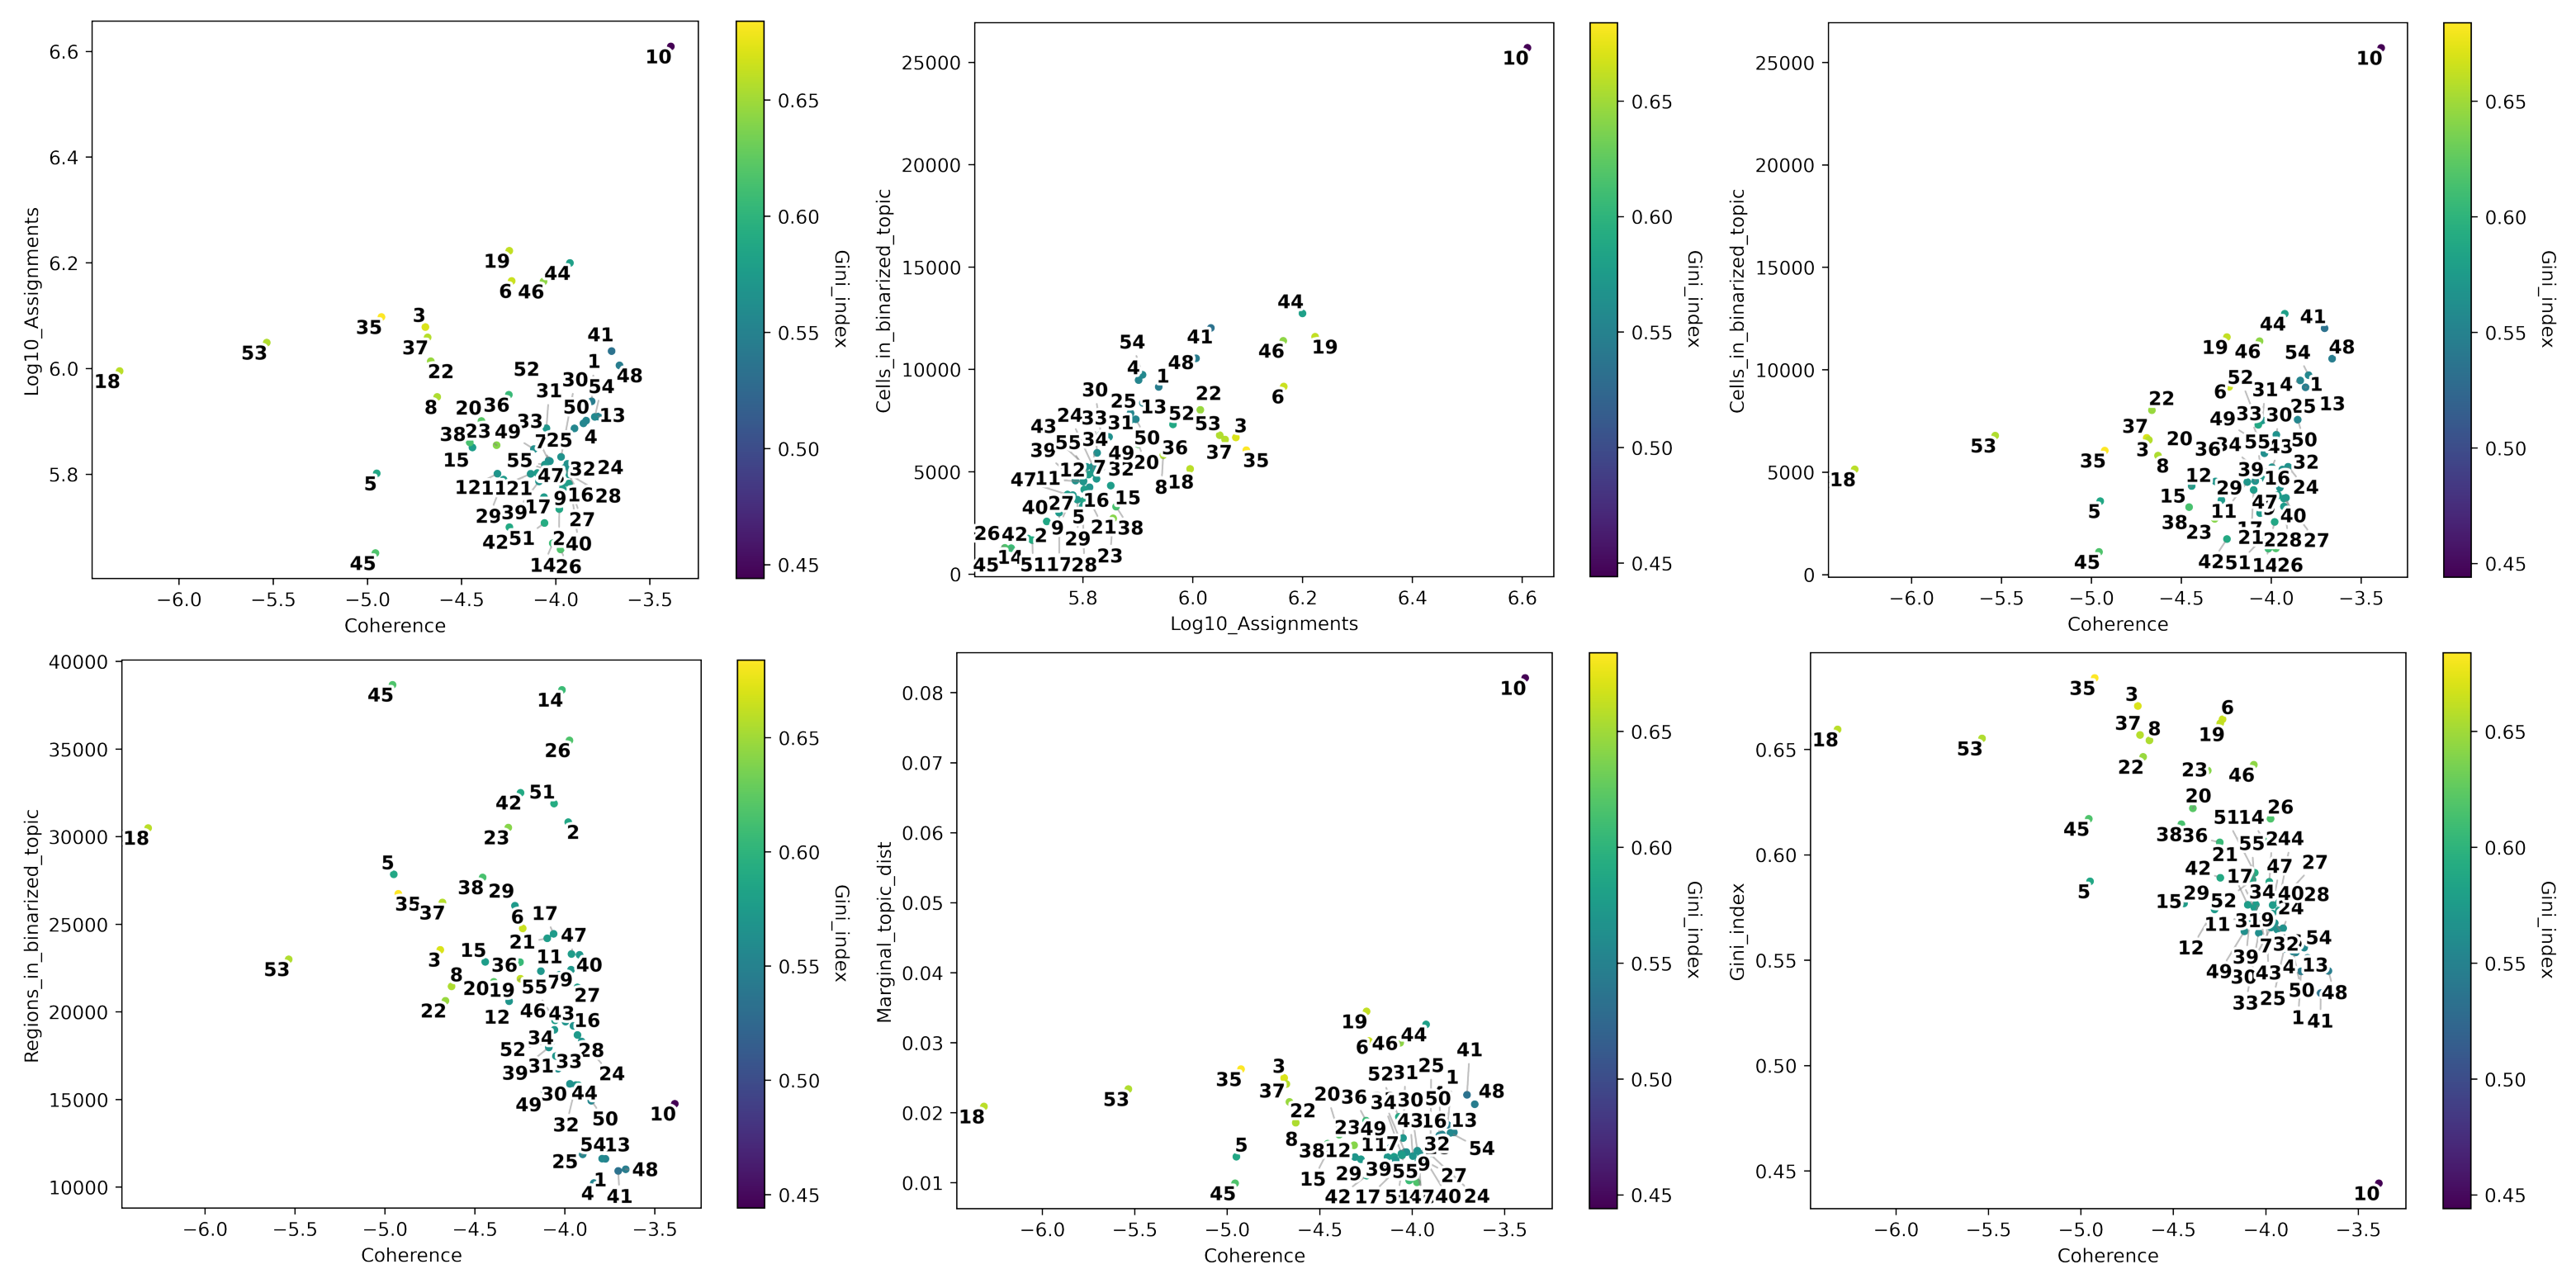

In [23]:
fig = plt.figure(figsize=(40, 43))
i = 1
for fig_ in fig_dict.keys():
    plt.subplot(2, 3, i)
    img = fig2img(fig_dict[fig_])
    plt.imshow(img)
    plt.axis('off')
    i += 1
plt.subplots_adjust(wspace=0, hspace=-0.70)
plt.show()

In [24]:
topic_annot = topic_annotation(
    cistopic_object,
    annot_var="Cell_type",
    binarized_cell_topic=binarized_cell_topic,
    general_topic_thr=0.2
)

/tscc/nfs/home/biy022/miniconda3/envs/scenicplus/lib/python3.11/site-packages/statsmodels/stats/weightstats.py:792: RuntimeWarning: divide by zero encountered in scalar divide
  zstat = value / std


## DAR

In [25]:
from pycisTopic.diff_features import (
    impute_accessibility,
    normalize_scores,
    find_highly_variable_features,
    find_diff_features
)
import numpy as np

In [26]:
imputed_acc_obj = impute_accessibility(
    cistopic_object,
    selected_cells=None,
    selected_regions=None,
    scale_factor=10**6
)

2025-03-05 13:44:07,663 cisTopic     INFO     Imputing region accessibility
2025-03-05 13:44:07,664 cisTopic     INFO     Impute region accessibility for regions 0-20000
2025-03-05 13:44:19,912 cisTopic     INFO     Impute region accessibility for regions 20000-40000
2025-03-05 13:44:32,164 cisTopic     INFO     Impute region accessibility for regions 40000-60000
2025-03-05 13:44:44,369 cisTopic     INFO     Impute region accessibility for regions 60000-80000
2025-03-05 13:44:56,535 cisTopic     INFO     Impute region accessibility for regions 80000-100000
2025-03-05 13:45:08,754 cisTopic     INFO     Impute region accessibility for regions 100000-120000
2025-03-05 13:45:20,979 cisTopic     INFO     Impute region accessibility for regions 120000-140000
2025-03-05 13:45:33,208 cisTopic     INFO     Impute region accessibility for regions 140000-160000
2025-03-05 13:45:45,445 cisTopic     INFO     Impute region accessibility for regions 160000-180000
2025-03-05 13:45:57,629 cisTopic     

In [27]:
normalized_imputed_acc_obj = normalize_scores(imputed_acc_obj, scale_factor=10**4)

2025-03-05 13:51:40,337 cisTopic     INFO     Normalizing imputed data
2025-03-05 13:55:19,180 cisTopic     INFO     Done!


2025-03-05 14:05:58,050 cisTopic     INFO     Calculating mean
2025-03-05 14:06:42,496 cisTopic     INFO     Calculating variance


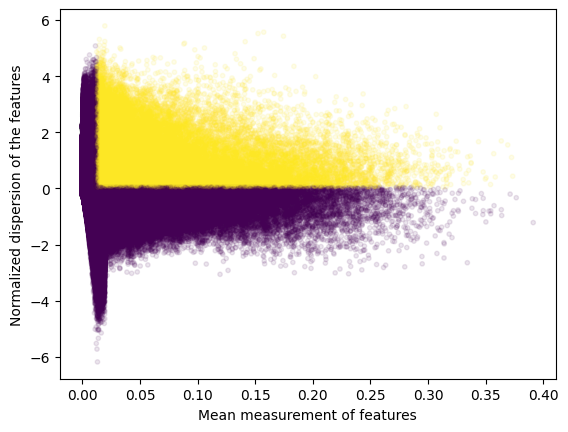

2025-03-05 14:11:34,613 cisTopic     INFO     Done!


In [28]:
variable_regions = find_highly_variable_features(
    normalized_imputed_acc_obj,
    min_disp=0.05,
    min_mean=0.0125,
    max_mean=3,
    max_disp=np.inf,
    n_bins=20,
    n_top_features=None,
    plot=True
)

In [29]:
len(variable_regions)

65054

In [30]:
markers_dict = find_diff_features(
    cistopic_object,
    imputed_acc_obj,
    variable="Cell_type",
    var_features=variable_regions,
    contrasts=None,
    adjpval_thr=0.05,
    log2fc_thr=np.log2(1),
    n_cpu=20,
    _temp_dir="/tscc/nfs/home/biy022/tmp/"
)

2025-03-05 14:12:04,868	INFO worker.py:1724 -- Started a local Ray instance.


2025-03-05 14:12:09,970 cisTopic     INFO     Subsetting data for VIP_1 (9037 of 53967)
2025-03-05 14:12:16,163 cisTopic     INFO     Computing p-value for VIP_1
2025-03-05 14:12:39,246 cisTopic     INFO     Computing log2FC for VIP_1
2025-03-05 14:12:41,553 cisTopic     INFO     VIP_1 done!
2025-03-05 14:12:41,659 cisTopic     INFO     Subsetting data for VIP_10 (850 of 53967)
2025-03-05 14:12:42,432 cisTopic     INFO     Computing p-value for VIP_10
2025-03-05 14:13:00,004 cisTopic     INFO     Computing log2FC for VIP_10
2025-03-05 14:13:00,312 cisTopic     INFO     VIP_10 done!
2025-03-05 14:13:00,411 cisTopic     INFO     Subsetting data for VIP_11 (4695 of 53967)
2025-03-05 14:13:01,282 cisTopic     INFO     Computing p-value for VIP_11
2025-03-05 14:13:18,865 cisTopic     INFO     Computing log2FC for VIP_11
2025-03-05 14:13:19,177 cisTopic     INFO     VIP_11 done!
2025-03-05 14:13:19,279 cisTopic     INFO     Subsetting data for VIP_12 (1091 of 53967)
2025-03-05 14:13:20,066 c

In [31]:
from pycisTopic.clust_vis import plot_imputed_features

In [32]:
print("Number of DARs found:")
print("---------------------")
for x in markers_dict:
    print(f"  {x}: {len(markers_dict[x])}")

Number of DARs found:
---------------------
  VIP_1: 25505
  VIP_10: 25102
  VIP_11: 25972
  VIP_12: 21198
  VIP_13: 27354
  VIP_14: 20785
  VIP_15: 21819
  VIP_16: 23085
  VIP_17: 19789
  VIP_18: 25275
  VIP_19: 28171
  VIP_2: 27001
  VIP_20: 27286
  VIP_21: 0
  VIP_22: 7952
  VIP_23: 23661
  VIP_24: 27584
  VIP_25: 24858
  VIP_26: 20473
  VIP_27: 20983
  VIP_28: 26201
  VIP_3: 27170
  VIP_4: 22898
  VIP_5: 22260
  VIP_6: 22929
  VIP_7: 21155
  VIP_8: 20903
  VIP_9: 26221


## Save region sets

In [33]:
os.makedirs("pycistopic_outputs/region_sets", exist_ok = True)
os.makedirs("pycistopic_outputs/region_sets/Topics_otsu", exist_ok = True)
os.makedirs("pycistopic_outputs/region_sets/Topics_top_3k", exist_ok = True)
os.makedirs("pycistopic_outputs/region_sets/DARs_celltypes", exist_ok = True)

In [34]:
from pycisTopic.utils import region_names_to_coordinates

In [35]:
for topic in region_bin_topics_otsu:
    region_names_to_coordinates(
        region_bin_topics_otsu[topic].index
    ).sort_values(["Chromosome", "Start", "End"]).to_csv(
        os.path.join("pycistopic_outputs/region_sets/Topics_otsu/", f"{topic}.bed"),
        sep="\t", header=False, index=False
    )

In [36]:
for topic in region_bin_topics_top_3k:
    region_names_to_coordinates(
        region_bin_topics_top_3k[topic].index
    ).sort_values(["Chromosome", "Start", "End"]).to_csv(
        os.path.join("pycistopic_outputs/region_sets/Topics_top_3k/", f"{topic}.bed"),
        sep="\t", header=False, index=False
    )

In [37]:
for subtype in markers_dict:
    subtype_name = subtype.replace(" ", "_").replace("/", "_")
    region_names_to_coordinates(
        markers_dict[subtype].index
    ).sort_values(["Chromosome", "Start", "End"]).to_csv(
        os.path.join("pycistopic_outputs/region_sets/DARs_celltypes/", f"{subtype_name}.bed"),
        sep="\t", header=False, index=False
    )